# Resnet Ablation Study

- "In the context of deep learning, what is an ablation study?"

저희가 지금부터 해볼 프로젝트는 애블레이션 연구(ablation study)입니다. 직역하자면 '제거 연구'정도가 되겠네요.

- 딥러닝 논문은 여러 가지 방법들을 결합해서 어떤 문제를 해결하는 방법을 제시합니다. 
- 이때 제안한 방법들의 유효함을 증명하기 위해서 보통 딥러닝 논문에서는 해당 방법을 "제거"한 모델로 수행한 실험과, 해당 방법을 추가한 모델로 수행한 실험의 결과를 비교합니다. 
- 애블레이션 연구란 이처럼 "아이디어를 제거해 봄으로써" 제안한 방법이 어떻게 성능이나 문제에 해결에 효과를 주는지 확인하는 실험입니다.

# Ablation Study 실습 (1) CIFAR-10 데이터셋 준비하기

ResNet이 막 공개된 시점으로 돌아갔다고 생각해 봅시다. 우리는 이 방법이 논문으로는 유효하다고 들었지만 직접 실험을 해 성능을 평가하고, 다른 실험에 적용해 보기로 합니다.

ResNet의 성능을 평가하기 위해서 원래 논문과 동일한 이미지넷의 훈련/검증 데이터셋을 사용해 학습과 평가를 진행하면 좋겠지만, 우리는 컴퓨팅 자원이 부족하므로 이미지넷보다는 적당한 크기의 CIFAR-10 데이터셋으로 평가해보도록 합시다.
지금부터 우리의 실험은 CIFAR-10에 대해 일반 네트워크와 ResNet을 구현해서 이 둘을 비교하여 ResNet 및 residual connection의 유효성을 확인하는 것입니다. ResNet에 대한 설명은 ResNet 이론 자료를 다시 한 번 확인하도록 합시다.

## 1) CIFAR-10

그럼 우리가 이번에 모델을 사용해서 풀어야 할 문제가 무엇인지 확인해보도록 합시다. CIFAR-10 데이터셋은 10개 카테고리에 대해 총 6만 장의 이미지가 있습니다. 각 이미지들의 가로, 세로는 각각 32 픽셀(pixel)입니다. MNIST에서 손글씨가 나타내는 숫자를 분류해내었던 것처럼 CIFAR-10 데이터셋을 사용해 물체의 종류를 분류해보도록 하겠습니다.

먼저 데이터셋을 준비하겠습니다. 컴퓨터에 텐서플로우에서 제공하는 tensorflow-datasets 패키지가 설치되어 있지 않다면 아래 명령어로 설치해 주세요.

- $ pip install tensorflow-datasets

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

CIFAR-10은 대용량 데이터셋은 아니지만 그래도 로드되는 데 꽤 긴 시간이 걸립니다. 잠깐 커피를 드시면서 숨을 돌리셔도 좋습니다.

데이터셋이 준비되면 클래스의 수와 클래스에 따른 이름을 볼 수 있습니다. DatasetBuilder의 info를 통해 정보를 확인해 보세요.

❗️ tfds.load()는 기본적으로 ~/tensorflow_datasets 경로에 데이터셋을 다운로드합니다. 데이터셋 크기가 커서 하나의 폴더에 모아놓고 사용하는 것도 좋은 방법이므로, ~/aiffel 프로젝트 폴더가 아닌 기본 경로에 다운 받아 사용하시면 됩니다. 혹시 데이터셋 경로를 바꾸고 싶으시다면, data_dir 인자를 사용하세요.

In [3]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [4]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [5]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


Tensorflow의 데이터셋은 Numpy가 아니므로 ds_train.shape 같은 게 존재하지 않습니다. 위와 같은 방법으로 데이터셋의 이미지 shape와 전체 데이터의 갯수, 라벨 클래스의 갯수 등 가장 중요한 정보들이 잘 확인되었나요?

## 2) Input Normalization

우리는 "가로 1920, 세로 1080 픽셀의 이미지"처럼 픽셀의 수를 사용해 이미지의 크기를 말할 수 있는데요. 이때 한 픽셀이 가진 채널(channel) 값은 픽셀의 색을 표현합니다. RGB는 Red, Green, Blue로 세 가지 색을 조합해서 우리가 보는 다양한 색을 만들어내는 방법이죠. 그레이 스케일(gray scale)은 단순하게 흑과 백만을 표현하는 하나의 채널을 가진 이미지입니다. RGB나 그레이 스케일 외에도 HSV, CMYK 등 인쇄 또는 이미지 작업을 위해 사용되는 다양한 채널 체계가 있습니다.

우리의 모델에 넣어주기 전에는 각 채널별 최댓값인 255로 정규화(normalize)를 해주어 이미지의 표현이 0과 1 사이로 들어오도록 만들어줍니다.

In [6]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [7]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

MNIST 데이터셋 클래스는 0부터 9까지의 숫자, 총 10가지가 있습니다. CIFAR-10 데이터셋 또한 이름에서 알 수 있듯이 10개 클래스를 가집니다. 아래 코드로 각 클래스가 어떻게 구성되는지, 어떤 이미지가 있는지 확인해 보세요!

In [8]:
ds_info.features["label"].num_classes

10

In [9]:
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

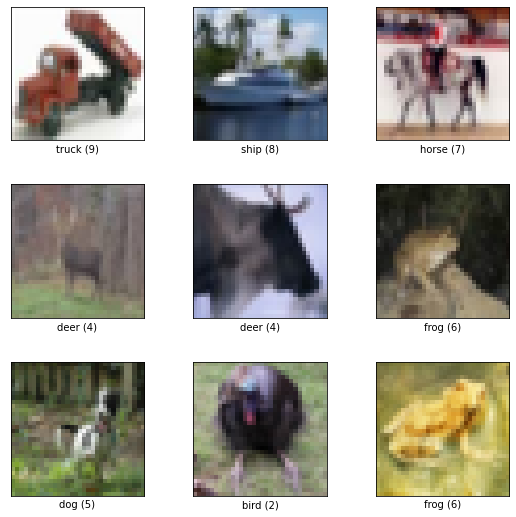

In [10]:
fig = tfds.show_examples(ds_train, ds_info)

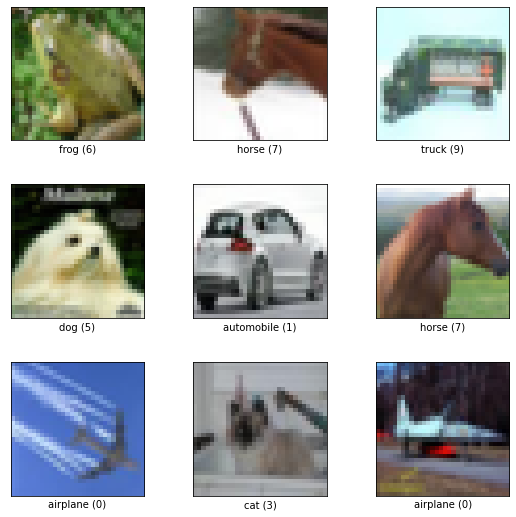

In [11]:
fig = tfds.show_examples(ds_test, ds_info)

모델의 학습을 위한 데이터셋에 대한 확인은 충분히 한 것 같습니다. 이제 본격적으로 코딩을 하면서 모델을 직접 빌딩하는 시간을 갖도록 하겠습니다.

## Ablation Study 실습 (2) 블록 구성하기
모델을 프로그램으로 구현하는 과정에서는 논문의 모델을 그대로 구현하는 것도 중요하지만, 구현 시에 반복되는 부분을 줄여서 하이퍼파라미터 또는 변수를 변경하거나 모델 구조가 변경될 때 손쉽게 바꿀 수 있도록 만들어 놓는 것이 필요합니다.

최근 나오는 일반적인 딥러닝 모델에서 이렇게 주요 구조를 모듈화 시켜 조금씩 바꾸어 쓸 수 있는 단위를 블록(block) 이라고 부릅니다. 레이어(layer) 는 기본적으로 텐서플로우(TensorFlow), 케라스(Keras), 파이토치(PyTorch) 등에서 기본적으로 제공하는 단위입니다. 우리는 여기서 한 단계 위인 "블록"을 단위로 모델을 만들 수 있어야 합니다.

프로젝트로 구현할 ResNet을 보면 ResNet-18, 34, 50, 101, 152로 다섯 가지 네트워크가 있습니다. 각 네트워크를 하나씩 구현하는 방법도 있지만 매우 수고스럽고 변경사항이 생기면 모두 고쳐줘야 하는 불편함이 생기게 됩니다. 따라서 이후 실습에서 우리는 ResNet의 기본 구조인 블록을 먼저 구현하겠습니다.

ResNet을 바로 구현하는 것은 어려울 수 있으므로, 지금부터 조금 더 간단한 블록이 반복되는 VGG를 예시로 구현해 보겠습니다.

## VGG 기본 블록 만들기

![VGG](vgg_structure.max-800x600.png)

VGG는 여러 가지 버전이 있습니다. 이 중 VGG의 VGG-16과 VGG-19의 기본 구조가 되는 블록을 만든다고 가정하고 블록을 구현해 봅시다.

블록을 구현하기 위해 모델 구조의 특징을 짚어보겠습니다. VGG의 블록은 개략적으로 CNN 레이어 여러 개와 Max pooling 레이어 한 개로 이루어집니다. CNN은 모두 커널 크기가 3x3 라는 대표적인 특징을 가지고 있습니다. 그리고 블록 내 CNN 레이어의 채널은 하나로 유지되지만 서로 다른 블록 간 CNN 레이어의 채널 수는 다를 수 있습니다. 블록에 따라서 CNN 레이어의 갯수 또한 달라집니다. 블록의 마지막에는 항상 Max Pooling 레이어가 붙습니다. 따라서 우리의 블록은 CNN 레이어 여러 개와 Max pooling 레이어 한 개로 이루어질 것이고, CNN의 레이어 수와 채널을 조절할 수 있어야 합니다.

block_num은 레이어의 이름을 붙여주기 위해서 추가되었고 input_shape는 summary를 출력하기 위해서 넣어주었습니다.

In [12]:
# function for building VGG Block

def build_vgg_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                   ):
    # 입력 레이어
    x = input_layer

    # CNN 레이어
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)    

    # Max Pooling 레이어
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
        name=f'block{block_num}_pooling'
    )(x)

    return x

이제 위에서 만든 VGG 블록을 추가하는 함수를 이용해서 input_layer 에 추가를 해 봅시다. 입력 레이어는 아까 데이터셋에서 확인한 32, 32의 가로 세로 크기를 가지고 채널로 3을 가지므로 (32,32,3) 이 됩니다. 이 입력 레이어를 인자로 받아 build_vgg_block() 는 블록의 레이어를 build하고 출력값을 얻을 수 있습니다. 이제 케라스의 Model 클래스에서 input과 output을 정의해주면 간단히 블록의 모델을 확인해볼 수 있습니다.



In [13]:
vgg_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
vgg_block_output = build_vgg_block(vgg_input_layer)    # VGG 블록 생성

In [14]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=vgg_input_layer, outputs=vgg_block_output)  

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 16, 16, 64)        0         
Total params: 75,648
Trainable params: 75,648
Non-trainable params: 0
_________________________________________________________________


## Ablation Study 실습 (3) VGG Complete Model
이제 기본적인 블록을 만들 수 있는 함수를 만들었으니 이를 합쳐서 전체 모델을 만들 수 있는 함수를 만들어보겠습니다.

### 1) VGG-16
먼저 작은 네트워크인 VGG-16을 먼저 만들어 보겠습니다. 블록 내의 CNN 레이어 수와 채널 수는 블록마다 달라집니다. 이는 VGG-16과 VGG-19에 따라서 같이 변화되므로 함수에 전달되어야 합니다. 여기서는 각 블록 별 CNN의 수와 채널을 리스트로 전달했습니다.

In [15]:
# VGG 모델 자체를 생성하는 함수입니다.
def build_vgg(input_shape=(32,32,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=10):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )
        
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )

    return model

In [16]:
# 기본값을 그대로 사용해서 VGG 모델을 만들면 VGG-16이 됩니다.
vgg_16 = build_vgg()

vgg_16.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

### 2) VGG-19
위에서 16을 만들어봤으니 쉽게 구성(configuration)을 바꿔서 VGG-19를 만들 수 있습니다.

In [17]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 줍니다.
vgg_19 = build_vgg(
    num_cnn_list=[2,2,4,4,4],
    channel_list=[64,128,256,512,512]
)

vgg_19.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

## Ablation Study 실습 (4) VGG-16 vs VGG-19
이제 본격적으로 위에서 준비한 데이터셋과 모델의 성능 비교를 위해서 모델을 훈련하고 평가하겠습니다.

VGG는 레이어의 차이를 위해서 VGG-16과 VGG-19를 비교해보도록 하겠습니다.

우선 CIFAR-10 데이터셋을 불러옵시다.

In [19]:
BATCH_SIZE = 256
EPOCH = 40

In [20]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

### VGG-16 모델을 만들고 훈련시켜 줍니다.

잠깐! 이 작업은 시간이 상당히 소요됩니다. BATCH_SIZE가 커지면 소요시간이 좀 줄어드는 효과가 있습니다만, 1epoch당 1분 이상 소요될 수도 있습니다. 이 훈련은 40Epoch 정도 수행하는 것을 권장하지만, 20Epoch 정도로도 어느정도 근접하는 성능을 얻을 수는 있을 것입니다.

In [21]:
vgg_16.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_16 = vgg_16.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/40
195/195 [==============================] - 34s 176ms/step - loss: 2.1954 - accuracy: 0.1876 - val_loss: 2.0707 - val_accuracy: 0.2413
Epoch 2/40
195/195 [==============================] - 24s 122ms/step - loss: 2.0035 - accuracy: 0.2755 - val_loss: 1.9058 - val_accuracy: 0.3233
Epoch 3/40
195/195 [==============================] - 17s 85ms/step - loss: 1.8708 - accuracy: 0.3244 - val_loss: 1.8295 - val_accuracy: 0.3480
Epoch 4/40
195/195 [==============================] - 17s 87ms/step - loss: 1.7604 - accuracy: 0.3676 - val_loss: 1.6930 - val_accuracy: 0.3988
Epoch 5/40
195/195 [==============================] - 16s 84ms/step - loss: 1.6818 - accuracy: 0.3951 - val_loss: 1.6340 - val_accuracy: 0.4110
Epoch 6/40
195/195 [==============================] - 17s 85ms/step - loss: 1.6165 - accuracy: 0.4206 - val_loss: 1.6127 - val_accuracy: 0.4184
Epoch 7/40
195/195 [==============================] - 17s 85ms/step - loss: 1.5613 - accuracy: 0.4345 - val_loss: 1.6072 - val_accurac

### VGG-19 모델을 만들고 훈련시켜 줍니다.

파라미터가 더 많은 VGG-19는 VGG-16보다 1/4 정도 훈련 시간이 더 걸립니다. Epoch 수나 BATCH_SIZE를 잘 조절해 주세요.

In [22]:
vgg_19.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_19 = vgg_19.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/40
195/195 [==============================] - 19s 99ms/step - loss: 2.2319 - accuracy: 0.1584 - val_loss: 2.1211 - val_accuracy: 0.2250
Epoch 2/40
195/195 [==============================] - 19s 97ms/step - loss: 2.0327 - accuracy: 0.2571 - val_loss: 1.9561 - val_accuracy: 0.2727
Epoch 3/40
195/195 [==============================] - 19s 98ms/step - loss: 1.8911 - accuracy: 0.3116 - val_loss: 1.8826 - val_accuracy: 0.3109
Epoch 4/40
195/195 [==============================] - 20s 101ms/step - loss: 1.7745 - accuracy: 0.3572 - val_loss: 1.6798 - val_accuracy: 0.4086
Epoch 5/40
195/195 [==============================] - 20s 102ms/step - loss: 1.6856 - accuracy: 0.3908 - val_loss: 1.6612 - val_accuracy: 0.3952
Epoch 6/40
195/195 [==============================] - 20s 100ms/step - loss: 1.6214 - accuracy: 0.4139 - val_loss: 1.5862 - val_accuracy: 0.4351
Epoch 7/40
195/195 [==============================] - 20s 101ms/step - loss: 1.5730 - accuracy: 0.4306 - val_loss: 1.5645 - val_accur

이제 VGG-16과 VGG-19를 그래프를 그리고 비교해보도록 하겠습니다. 먼저 훈련 손실(training loss)이 어떻게 다르게 진행되는지 비교해봅시다.

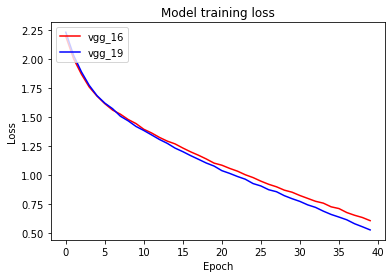

In [24]:
import matplotlib.pyplot as plt

plt.plot(history_16.history['loss'], 'r')
plt.plot(history_19.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

그리고 검증 정확도(validation accuracy)를 비교해 봅시다.

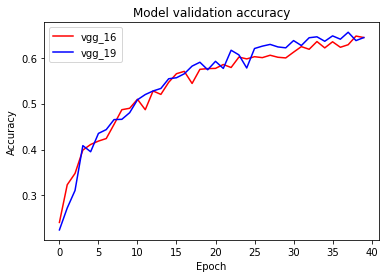

In [25]:
plt.plot(history_16.history['val_accuracy'], 'r')
plt.plot(history_19.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

VGG-19가 조금 더 높은 정확도를 보입니다. 이후의 그래프를 더 보려면 epochs 를 늘려서 학습시켜 보시기 바랍니다.